# New York Taxi Analysis

Data can be found here: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page (January 2019 Dataset)

In this project, we are trying to predict the average income of a taxi driver in New York City, per hour and per region as it is divided in the dataset.

## Table of Contents <a id='table_of_contents'></a>

0. [Import libraries](#imports)
1. [Import data](#import_data)
2. [Data exploration](#data_exploration)
3. [Data cleaning](#data_cleaning)
4. [Data preparation](#data_preparation)
5. [Benchmark model](#benchmark_model)<br>
    5.1 [Train-Test Spit](#train_test_split)<br>
    5.2 [Fit A Model To The Data](#fit_a_model_to_the_data)<br>
    5.3. [Model Evaluation](#model_evaluation)<br>
    5.4. [Fix The Problem](#fix_the_problem)
6. [Feature engineering](#feature_engineering)<br>
    6.1. [Date-Related Features](#date_related_features)<br>
    6.2. [Borough Information](#borough_information)<br>
    6.3. [Weather-Related Features](#weather_related_features)
7. [Model training](#model_training)<br>
    7.1. [Decision Tree](#decision_tree)<br>
    7.2. [Random Forest](#random_forest)<br>
    7.3. [Gradient Boosting](#gradient_boosting)<br>
    7.4. [Comparing algorithm performances](#comparing_algorithm_performances)
8. [Tuning](#tuning)<br>

## 0. Import Libraries <a id='imports'></a>
[Back to top](#table_of_contents)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

%matplotlib inline

%load_ext autoreload
%autoreload 2

## 1. Import Data <a id='imports_data'></a>
[Back to top](#table_of_contents)

In [2]:
# Load the data 
taxi_df = pd.read_csv('data/yellow_tripdata_2019-01.csv')

In [3]:
# Examine the first 5 entries 
taxi_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


In [4]:
# The data has 7,667,792 rows and 18 columns 
taxi_df.shape

(7667792, 18)

## 2. Data Exploration <a id='data_exploration'></a>
[Back to top](#table_of_contents)

**First**, drop irrelevant / unhelpful columns
Metadata can be found here: https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

*Columns to drop:* 
- VendorID: A code indicating the TPEP provider that provided the record.
- store_and_fwd_flag: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.
- payment_type: A numeric code signifying how the passenger paid for the trip (can be good to keep if there are problems with the data). 
- tip_amount: Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.
- fare_amount, etra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, congestion_surcharge: we only care about the total_amount

In [5]:
taxi_data = taxi_df[['tpep_pickup_datetime', 'tpep_dropoff_datetime',
                       'passenger_count', 'trip_distance', 'RatecodeID', 
                       'PULocationID', 'DOLocationID', 'payment_type',
                       'total_amount']]

In [6]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,151,239,1,9.95
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,239,246,1,16.30
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,236,236,1,5.80
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,193,193,2,7.55
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,193,193,2,55.55


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DFDBEA5B48>,
      dtype=object)

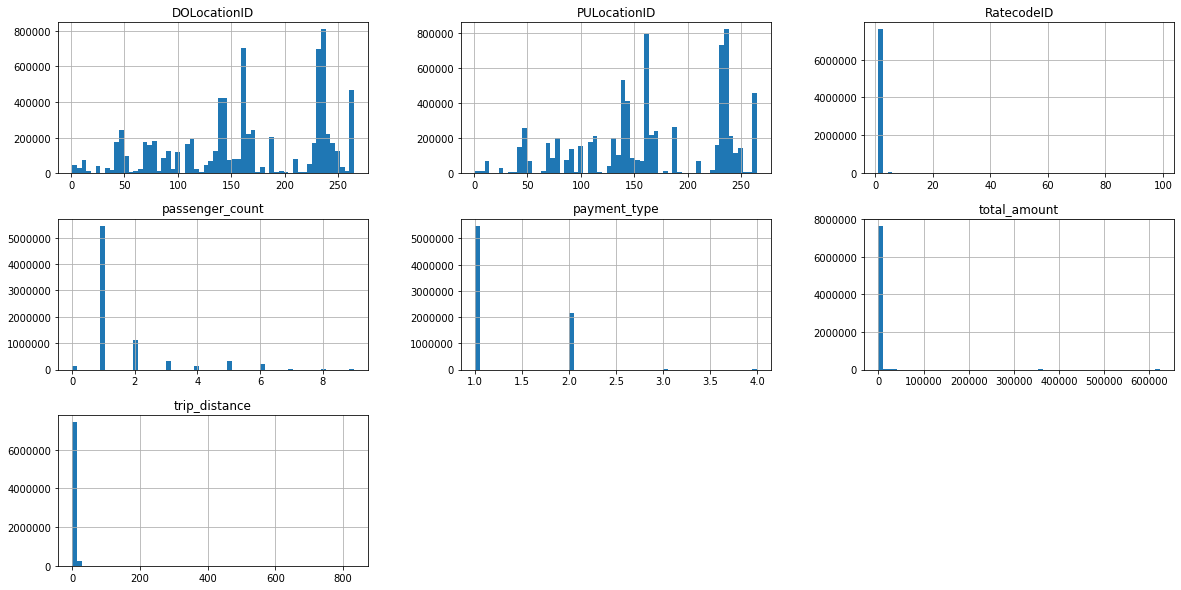

In [7]:
taxi_data.hist(figsize=(20,10), bins=60)

In [8]:
taxi_data['RatecodeID'].value_counts()

1     7430139
2      166090
5       54569
3       11801
4        4895
99        252
6          46
Name: RatecodeID, dtype: int64

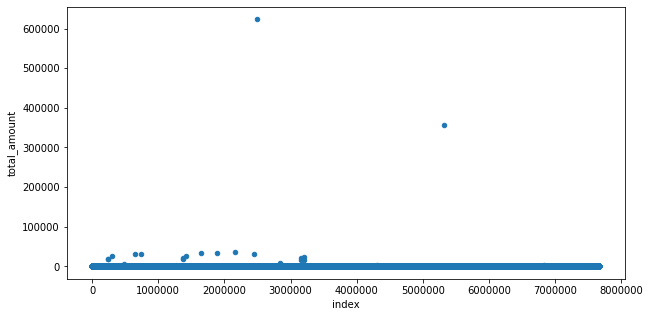

In [9]:
# Observation: There are clearly outliers 

taxi_data.reset_index().plot(kind='scatter', y='total_amount', 
                             x='index', figsize=(10,5))

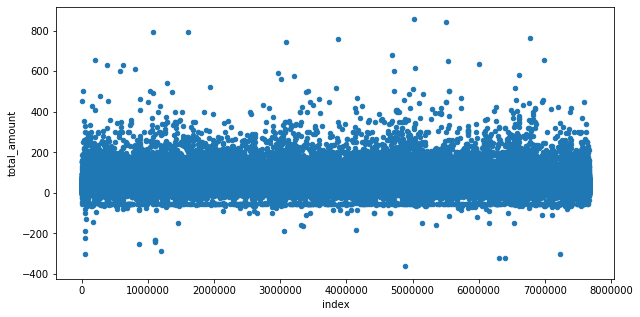

In [10]:
# Observation: A lot of data lies below 1000
# But, we have some negative values to deal with 

taxi_data[taxi_data['total_amount']<1000].reset_index().plot(
    kind='scatter', y='total_amount', x='index', figsize=(10,5))

We have two things to deal with: 
(1) Negative values 
(2) Very high values 

##### Negative Values and Zero Values

Only a very small amount of data (1 in 1000) with negative values of total amount. 
Most of these have payment type of 3 (no charge) or 4 (dispute).
Negative values are probably not going to help the model, so we are going to delete them. 

There are even a smaller amount of data (1 in 7000) with zero total amount. 
Most of these data have zero trip distance. 
Zero values are probably not going to help the model, so we are going to delete them. 

(7131, 9)


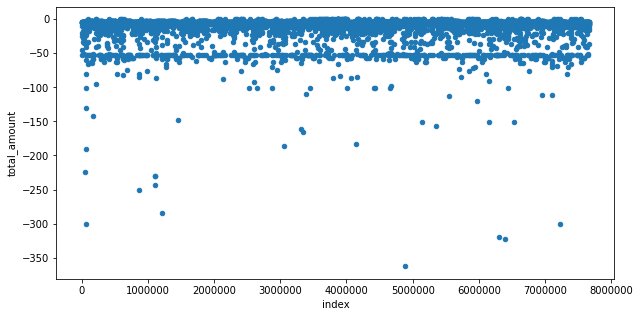

In [11]:
# There are about 7000 negative entries, and more than 7,000,000 entries in total
# We can delete these negative entries without losing too much data

print(taxi_data[taxi_data['total_amount'] < 0].shape)
taxi_data[taxi_data['total_amount'] < 0].reset_index().plot(
    kind='scatter', y='total_amount', x='index', figsize=(10,5))

In [12]:
taxi_data[taxi_data['total_amount'] < 0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
663,2019-01-01 00:32:56,2019-01-01 00:33:35,2,0.10,1,148,148,3,-3.8
2402,2019-01-01 00:14:18,2019-01-01 00:40:55,1,4.13,1,170,238,4,-20.3
2541,2019-01-01 00:31:27,2019-01-01 00:42:39,1,1.35,1,162,234,4,-9.8
2544,2019-01-01 00:45:57,2019-01-01 00:46:07,1,0.00,1,234,234,4,-3.8
2547,2019-01-01 00:48:35,2019-01-01 00:49:59,1,0.16,1,234,234,4,-4.3


In [13]:
# Most of negative data has payment_types of 3 (no charge) or 4 (dispute)

taxi_data[taxi_data['total_amount'] < 0]['payment_type'].value_counts()

3    4088
4    2666
2     376
1       1
Name: payment_type, dtype: int64

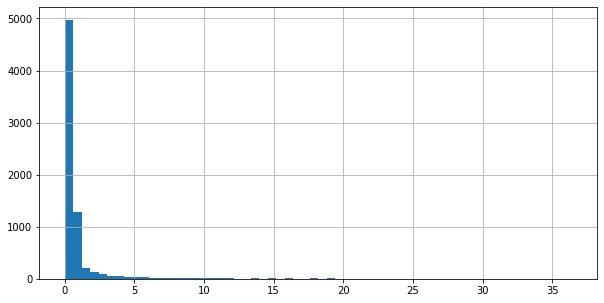

In [14]:
# Most of these have very short trip distance anyway
taxi_data[taxi_data['total_amount'] < 0]['trip_distance'].hist(bins=60, figsize=(10,5))

In [15]:
print(taxi_data[taxi_data['total_amount']==0].shape)
taxi_data[taxi_data['total_amount']==0].head()

(1414, 9)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
3552,2019-01-01 00:18:46,2019-01-01 00:18:46,1,0.0,5,186,264,2,0.0
9138,2019-01-01 00:41:47,2019-01-01 00:41:47,1,0.0,5,246,264,2,0.0
13256,2019-01-01 00:19:38,2019-01-01 00:20:35,1,0.0,1,193,193,1,0.0
13257,2019-01-01 00:43:34,2019-01-01 00:43:34,1,0.0,1,7,7,2,0.0
13258,2019-01-01 00:02:52,2019-01-01 00:02:52,1,0.0,1,264,7,2,0.0


In [16]:
taxi_data[taxi_data['total_amount']==0]['payment_type'].value_counts()

1    815
2    569
3     29
4      1
Name: payment_type, dtype: int64

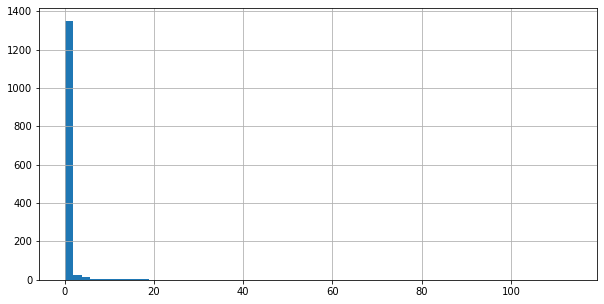

In [17]:
taxi_data[taxi_data['total_amount']==0]['trip_distance'].hist(bins=60, figsize=(10,5))

In [18]:
# Most of 0 entries have 0 trip distance, which makes sense
taxi_data[taxi_data['total_amount']==0]['trip_distance'].value_counts()

0.00    1270
1.00       4
0.01       4
0.02       4
0.03       3
        ... 
0.59       1
0.18       1
5.70       1
0.87       1
1.04       1
Name: trip_distance, Length: 110, dtype: int64

##### Very High Values

We agree to cut from $200 level.

In [19]:
# We are looking for a safe cut-off point
# Remember, we have more than 7,000,000 data points 

print('No. of data with total amount above 500:', taxi_data[taxi_data['total_amount']>500].shape)
print('No. of data with total amount above 300:', taxi_data[taxi_data['total_amount']>300].shape)
print('No. of data with total amount above 200:', taxi_data[taxi_data['total_amount']>200].shape)
print('No. of data with total amount above 100:', taxi_data[taxi_data['total_amount']>100].shape)

No. of data with total amount above 500: (56, 9)
No. of data with total amount above 300: (307, 9)
No. of data with total amount above 200: (1166, 9)
No. of data with total amount above 100: (10832, 9)


In [20]:
# Mean total amount is $15.68

taxi_data['total_amount'].describe()

count    7.667792e+06
mean     1.568222e+01
std      2.622932e+02
min     -3.628000e+02
25%      8.190000e+00
50%      1.127000e+01
75%      1.656000e+01
max      6.232617e+05
Name: total_amount, dtype: float64

## 3. Data Cleaning <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

In [21]:
taxi_data.shape

(7667792, 9)

In [22]:
taxi_data_filtered = taxi_data[(taxi_data['total_amount']>0) & 
                                (taxi_data['total_amount']<200)]
taxi_data_filtered.shape

(7658076, 9)

Check for missing values 

In [23]:
taxi_data_filtered.isna().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
total_amount             0
dtype: int64

## 4. Data Preparation <a id='data_preparation'></a>
[Back to top](#table_of_contents)

Data preparation is the process of cleaning and transforming raw data prior to processing and analysis. It is an important step prior to processing and often involves reformatting data, making corrections to data and the combining of data sets to enrich data.

In [24]:
taxi_data_prepared = taxi_data_filtered.copy()

Make sure everyhing is the right type

In [25]:
taxi_data_prepared.dtypes

tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
PULocationID               int64
DOLocationID               int64
payment_type               int64
total_amount             float64
dtype: object

Cast tpep_pickup_datetime and tpep_dropoff_datetime to datetime type

In [26]:
taxi_data_prepared.loc[:,'tpep_pickup_datetime'] = pd.to_datetime(taxi_data_prepared.loc[:,'tpep_pickup_datetime'])
taxi_data_prepared.loc[:,'tpep_dropoff_datetime'] = pd.to_datetime(taxi_data_prepared.loc[:,'tpep_dropoff_datetime'])

In [27]:
taxi_data_prepared.loc[:, 'RatecodeID'] = taxi_data_prepared['RatecodeID'].astype(str)
taxi_data_prepared.loc[:, 'PULocationID'] = taxi_data_prepared['PULocationID'].astype(str)
taxi_data_prepared.loc[:, 'DOLocationID'] = taxi_data_prepared['DOLocationID'].astype(str)
taxi_data_prepared.loc[:, 'payment_type'] = taxi_data_prepared['payment_type'].astype(str)

In [28]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                       object
PULocationID                     object
DOLocationID                     object
payment_type                     object
total_amount                    float64
dtype: object

Transforming variables into the formats we need them 

In [29]:
taxi_data_prepared['transaction_date']=taxi_data_prepared.tpep_pickup_datetime.dt.date
taxi_data_prepared['transaction_year']=taxi_data_prepared.tpep_pickup_datetime.dt.year
taxi_data_prepared['transaction_month']=taxi_data_prepared.tpep_pickup_datetime.dt.month
taxi_data_prepared['transaction_day']=taxi_data_prepared.tpep_pickup_datetime.dt.day
taxi_data_prepared['transaction_hour']=taxi_data_prepared.tpep_pickup_datetime.dt.hour

In [30]:
taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transaction_date,transaction_year,transaction_month,transaction_day,transaction_hour
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,151,239,1,9.95,2019-01-01,2019,1,1,0
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,239,246,1,16.30,2019-01-01,2019,1,1,0
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,236,236,1,5.80,2018-12-21,2018,12,21,13
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,193,193,2,7.55,2018-11-28,2018,11,28,15
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,193,193,2,55.55,2018-11-28,2018,11,28,15


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E121967488>,
      dtype=object)

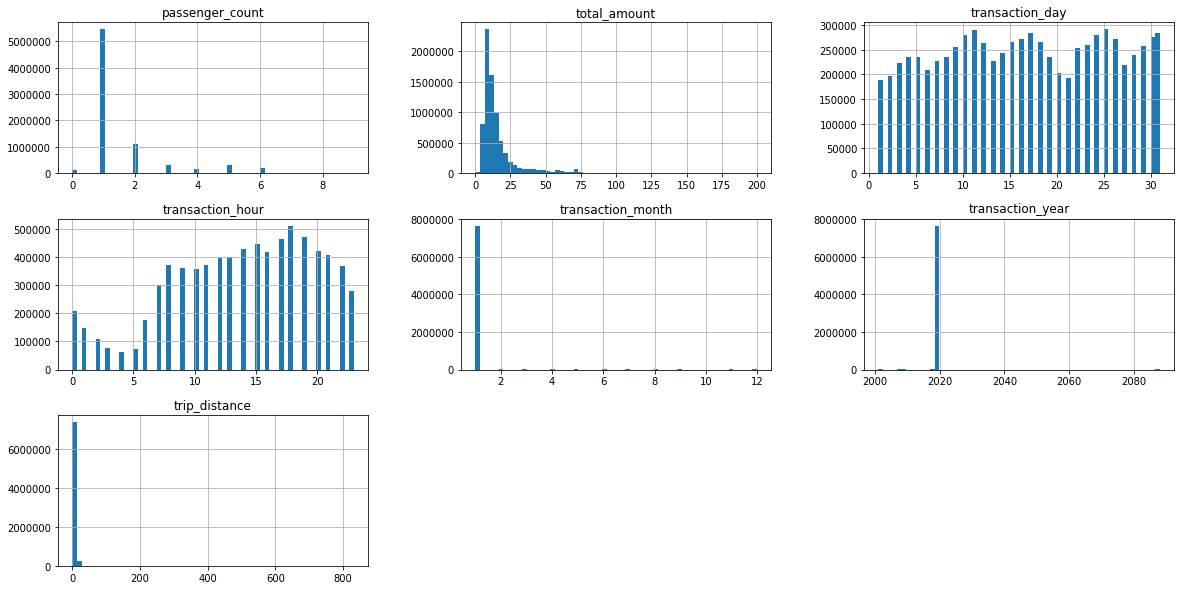

In [31]:
taxi_data_prepared.hist(bins=60, figsize=(20,10))

The data seems to contain data from time that are not in January 2019. This is not expected given the dataset we downloaded. We should drop these entries. 

In [32]:
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared.transaction_year == 2019]
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared.transaction_month == 1]

Noting down categorical and numerical columns 

In [33]:
categorical_columns = ['PULocationID', 'transaction_date', 'transaction_month', 'transaction_day', 'transaction_hour']
numerical_columns = ['trip_distance', 'total_amount']
all_needed_columns = categorical_columns + numerical_columns

In [34]:
# Leaving only the data that we need (the rest were only useful for data preparation)

main_taxi_df = taxi_data_prepared[all_needed_columns]
print(main_taxi_df.shape)
main_taxi_df.head()

(7657544, 7)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount
0,151,2019-01-01,1,1,0,1.5,9.95
1,239,2019-01-01,1,1,0,2.6,16.30
7,163,2019-01-01,1,1,0,1.3,9.05
8,229,2019-01-01,1,1,0,3.7,18.50
9,141,2019-01-01,1,1,0,2.1,13.00


Aggregate data points 

Now is a good time to think about what we want to predict. Depending on this, we need to transform our data to have a certain format.

In [35]:
taxi_grouped_by_region = main_taxi_df.groupby(categorical_columns).mean().reset_index()
taxi_grouped_by_region['count_of_transactions'] = main_taxi_df.groupby(categorical_columns).count().reset_index()['total_amount']
print(taxi_grouped_by_region.shape)
taxi_grouped_by_region.head()

(102521, 8)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2019-01-01,1,1,2,0.0,21.800,1
1,1,2019-01-01,1,1,5,0.0,87.300,1
2,1,2019-01-01,1,1,6,0.0,80.300,1
3,1,2019-01-01,1,1,8,0.0,128.580,2
4,1,2019-01-01,1,1,10,16.9,43.245,4


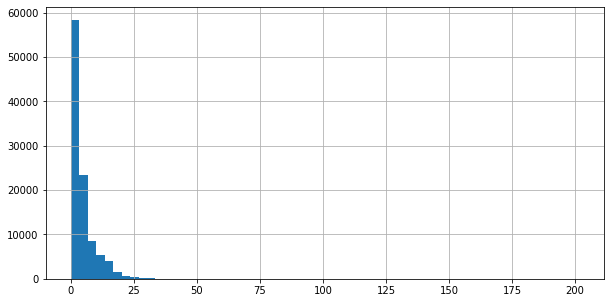

In [36]:
taxi_grouped_by_region.trip_distance.hist(bins=60, figsize=(10,5))

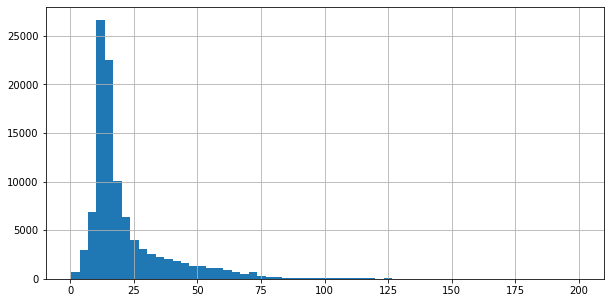

In [37]:
taxi_grouped_by_region.total_amount.hist(bins=60, figsize=(10,5))

## 5. Benchmark Model <a id='benchmark_model'></a>
[Back to top](#table_of_content)

This part contains a couple of steps: 
- Select input features and target feature
- Encoding categorical features (OneHotEncoding used in this case) 
- Train-test split (here, 2/3 of the data is used for training, 1/3 is used for test) 
- Fit a model (here, we use DecisionTreeRegression)
- Evaluate model (using mean absolute error, mean squared error, root mean squared error, R2-score) 
- Rule out possible leakage

In [38]:
data_for_benchmark_model = taxi_grouped_by_region.copy()

In [39]:
categorical_features_benchmark = ['PULocationID', 'transaction_month', 'transaction_day', 'transaction_hour']
input_features_benchmark = categorical_features_benchmark + ['trip_distance']
target_feature_benchmark = 'total_amount'

### 5.1. Train-Test Split<a id="train_test_split"></a>
[Back to top](#table_of_contents)

In [40]:
from sklearn.model_selection import train_test_split

X_bench = data_for_benchmark_model[input_features_benchmark]
y_bench = data_for_benchmark_model[target_feature_benchmark]

# One-hot encoding
X_bench = pd.get_dummies(X_bench)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.33, random_state=42)

### 5.2. Fit a model to the data <a id='fit_a_model_to_the_data'></a>
[Back to top](#table_of_contents)

In [41]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_b, y_train_b)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

### 5.3. Model Evaluation <a id="model_evaluation"></a>
[Back to top](#table_of_contents)

In [42]:
model_at_hand = tree
y_pred_b = model_at_hand.predict(X_test_b)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test_b, y_pred_b))
print('mean_squared_error', mean_squared_error(y_test_b, y_pred_b)) # exaggerate bigger differences (small errors are fine, big errors are not)
print('root_mean_squared_error', sqrt(mean_squared_error(y_test_b, y_pred_b))) # we want this to be at the same level as MAE
print('r2', r2_score(y_test_b, y_pred_b)) # how good our model fits the pattern of the data

mean_absolute_error 3.3827403852905316
mean_squared_error 63.50546426690318
root_mean_squared_error 7.969031576477984
r2 0.769549625832135


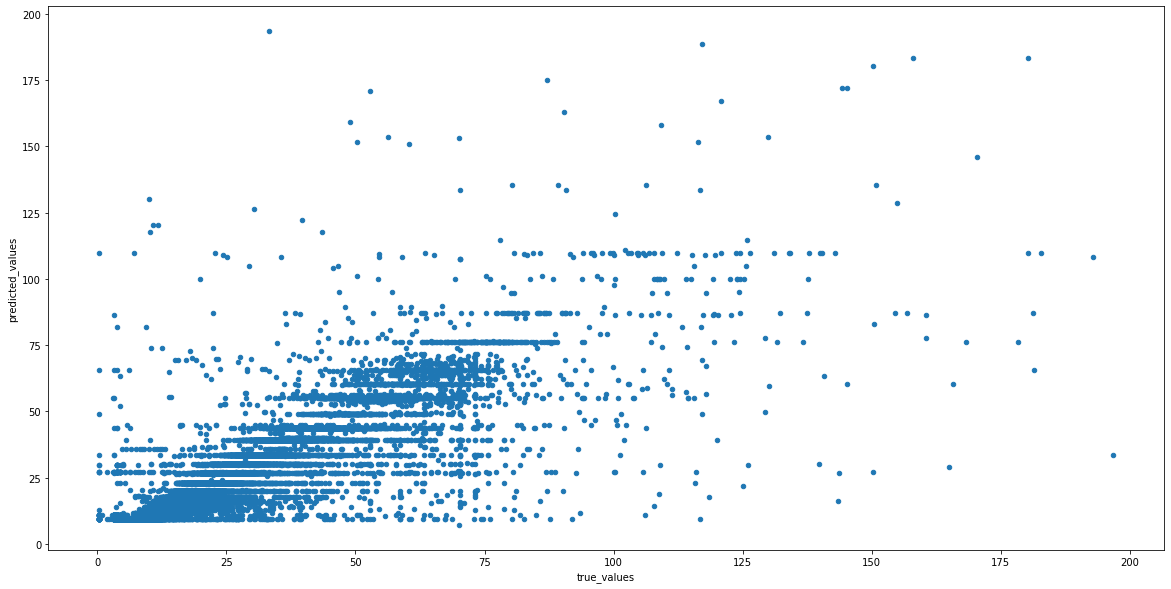

In [43]:
data = {'true_values': y_test_b, 'predicted_values': y_pred_b}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true_values', y='predicted_values')

This seems to good to be true. 

Problem identified: Leakage (by including trip_distance)

### 5.4 Fix the problem <a id="fix_the_problem"></a>
[Back to top](#table_of_contents)

In [44]:
categorical_features_benchmark = ['PULocationID', 'transaction_month', 'transaction_day', 'transaction_hour']
input_features_benchmark = categorical_features_benchmark 
target_feature_benchmark = 'total_amount'

from sklearn.model_selection import train_test_split

X_bench = data_for_benchmark_model[input_features_benchmark]
y_bench = data_for_benchmark_model[target_feature_benchmark]

# One-hot encoding
X_bench = pd.get_dummies(X_bench)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.33, random_state=42)

from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_b, y_train_b)

model_at_hand = tree
y_pred_b = model_at_hand.predict(X_test_b)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test_b, y_pred_b))
print('mean_squared_error', mean_squared_error(y_test_b, y_pred_b)) # exaggerate bigger differences (small errors are fine, big errors are not)
print('root_mean_squared_error', sqrt(mean_squared_error(y_test_b, y_pred_b))) # we want this to be at the same level as MAE
print('r2', r2_score(y_test_b, y_pred_b)) # how good our model fits the pattern of the data

mean_absolute_error 9.757681391179212
mean_squared_error 216.1076481491936
root_mean_squared_error 14.700600264927742
r2 0.21578262671683068


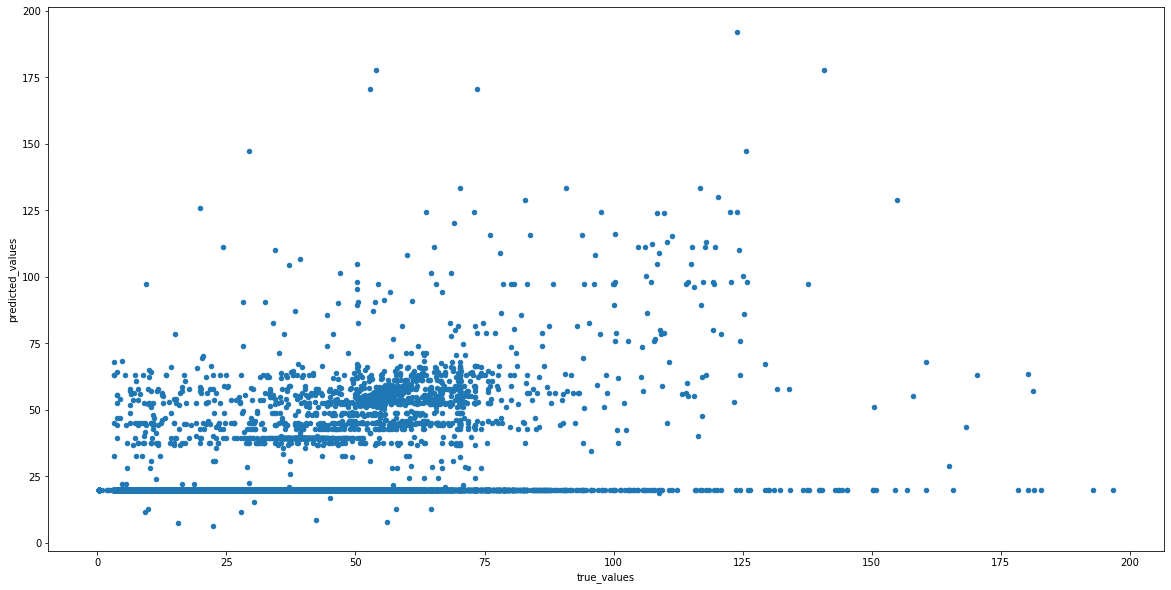

In [45]:
data = {'true_values': y_test_b, 'predicted_values': y_pred_b}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true_values', y='predicted_values')
# Best case scenario would be a straight line

## 6. Feature Engineering <a id="feature_engineering"></a>
[Back to top](#table_of_contents)

In [46]:
taxi_grouped_by_region.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2019-01-01,1,1,2,0.0,21.800,1
1,1,2019-01-01,1,1,5,0.0,87.300,1
2,1,2019-01-01,1,1,6,0.0,80.300,1
3,1,2019-01-01,1,1,8,0.0,128.580,2
4,1,2019-01-01,1,1,10,16.9,43.245,4


In [47]:
data_with_new_features = taxi_grouped_by_region.copy()

#### Date-related features <a id="date_related_features"></a>
[Back to top](#table_of_contents)

In [48]:
data_with_new_features['transaction_week_day'] = pd.to_datetime(data_with_new_features['transaction_date']).dt.weekday
data_with_new_features['weekend'] = data_with_new_features['transaction_week_day'].apply(lambda x: True if x==5 or x==6 else False)

In [49]:
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2018', 
                        end='2020').date

data_with_new_features['is_holiday'] = data_with_new_features['transaction_date'].isin(holidays)

In [50]:
data_with_new_features.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,True
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,True
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,True
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,True
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,True


#### Borough Information <a id="borough_information"></a>
[Back to top](#table_of_contents)

In [51]:
zone_lookup = pd.read_csv('data/taxi_zone_lookup.csv')
zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [52]:
zone_lookup = zone_lookup[['LocationID', 'Borough']]
zone_lookup.loc[:, 'LocationID'] = zone_lookup['LocationID'].astype(str)
zone_lookup.head()

,LocationID,Borough
0,1,EWR
1,2,Queens
2,3,Bronx
3,4,Manhattan
4,5,Staten Island


In [53]:
data_with_new_features = data_with_new_features.merge(zone_lookup, left_on='PULocationID', 
                                                    right_on='LocationID', how='left')
data_with_new_features.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,LocationID,Borough
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,True,1,EWR
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,True,1,EWR
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,True,1,EWR
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,True,1,EWR
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,True,1,EWR


In [54]:
data_with_new_features['Borough'].value_counts()

# It's likely that the performance of the model will improve if we consider only
# Manhattan, Brooklyn and Queens, as they have the most data

Manhattan        45309
Brooklyn         23632
Queens           21971
Bronx             9584
Unknown           1453
Staten Island      302
EWR                270
Name: Borough, dtype: int64

#### Weather Related Features <a id="weather_related_features"></a>
[Back to top](#table_of_contents)

In [55]:
weather = pd.read_csv('data/nyc_weather.csv')
weather.head()

,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation
0,31.12.2019 22:00,6.1,65,6,100%.,0.3
1,31.12.2019 19:00,6.7,71,5,70 – 80%.,NaN
2,31.12.2019 16:00,7.2,66,5,50%.,NaN
3,31.12.2019 13:00,6.1,76,3,100%.,Trace of precipitation
4,31.12.2019 10:00,4.4,83,2,100%.,Trace of precipitation


In [56]:
weather.isna().sum()

date and time                 0
temperature                   0
humidity                      0
wind speed                    0
cloud cover                   4
amount of precipitation    2240
dtype: int64

In [57]:
weather.dtypes

date and time               object
temperature                float64
humidity                     int64
wind speed                   int64
cloud cover                 object
amount of precipitation     object
dtype: object

In [58]:
weather['cloud cover'].value_counts()

70 – 80%.                                                     973
100%.                                                         896
20–30%.                                                       479
50%.                                                          413
no clouds                                                     168
Sky obscured by fog and/or other meteorological phenomena.      3
Name: cloud cover, dtype: int64

In [59]:
weather['cloud cover'] = weather['cloud cover'].replace('70 – 80%.', 0.75)
weather['cloud cover'] = weather['cloud cover'].replace('100%.', 1)
weather['cloud cover'] = weather['cloud cover'].replace('20–30%.', 0.25)
weather['cloud cover'] = weather['cloud cover'].replace('50%.', 0.5)
weather['cloud cover'] = weather['cloud cover'].replace('no clouds', 0)
weather['cloud cover'] = weather['cloud cover'].replace('Sky obscured by fog and/or other meteorological phenomena.', 1)
weather['cloud cover'] = weather['cloud cover'].interpolate()

In [60]:
weather['cloud cover'].value_counts()

0.75    973
1.00    903
0.25    479
0.50    413
0.00    168
Name: cloud cover, dtype: int64

In [61]:
weather['amount of precipitation'].value_counts().head()

Trace of precipitation    266
0.3                        61
2.0                        49
1.0                        45
0.5                        42
Name: amount of precipitation, dtype: int64

In [62]:
weather['amount of precipitation'] = weather['amount of precipitation'].replace('Trace of precipitation', 0.1)
weather['amount of precipitation'] = weather['amount of precipitation'].astype(float)
weather['amount of precipitation'] = weather['amount of precipitation'].interpolate()

In [63]:
weather.dtypes

date and time               object
temperature                float64
humidity                     int64
wind speed                   int64
cloud cover                float64
amount of precipitation    float64
dtype: object

In [64]:
weather.isna().sum()

date and time              0
temperature                0
humidity                   0
wind speed                 0
cloud cover                0
amount of precipitation    0
dtype: int64

In [65]:
weather.loc[:, 'date and time'] = pd.to_datetime(weather.loc[:, 'date and time'])
weather['month'] = weather['date and time'].dt.month
weather['day'] = weather['date and time'].dt.day
weather['hour'] = weather['date and time'].dt.hour

In [66]:
weather.head()

,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation,month,day,hour
0,2019-12-31 22:00:00,6.1,65,6,1.00,0.300000,12,31,22
1,2019-12-31 19:00:00,6.7,71,5,0.75,0.233333,12,31,19
2,2019-12-31 16:00:00,7.2,66,5,0.50,0.166667,12,31,16
3,2019-12-31 13:00:00,6.1,76,3,1.00,0.100000,12,31,13
4,2019-12-31 10:00:00,4.4,83,2,1.00,0.100000,12,31,10


In [67]:
data_with_new_features.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,LocationID,Borough
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,True,1,EWR
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,True,1,EWR
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,True,1,EWR
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,True,1,EWR
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,True,1,EWR


In [68]:
nyc_taxi_with_weather = data_with_new_features.merge(weather, 
                                                     left_on=['transaction_month', 'transaction_day', 'transaction_hour'],
                                                     right_on=['month', 'day', 'hour'], how='left')
nyc_taxi_with_weather.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,...,Borough,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation,month,day,hour
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,...,EWR,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,...,EWR,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,...,EWR,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,...,EWR,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,...,EWR,2019-01-01 10:00:00,15.6,62.0,11.0,0.75,0.473333,1.0,1.0,10.0


In [69]:
nyc_taxi_with_weather = nyc_taxi_with_weather.drop(columns=['month', 'day', 'hour'])

In [70]:
nyc_taxi_with_weather = nyc_taxi_with_weather.drop(columns=['date and time'])

In [71]:
nyc_taxi_with_weather.isna().sum()

PULocationID                   0
transaction_date               0
transaction_month              0
transaction_day                0
transaction_hour               0
trip_distance                  0
total_amount                   0
count_of_transactions          0
transaction_week_day           0
weekend                        0
is_holiday                     0
LocationID                     0
Borough                        0
temperature                68347
humidity                   68347
wind speed                 68347
cloud cover                68347
amount of precipitation    68347
dtype: int64

In [72]:
nyc_taxi_with_weather = nyc_taxi_with_weather.sort_values(by=['transaction_month', 'transaction_day', 'transaction_hour'])
nyc_taxi_with_weather.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,LocationID,Borough,temperature,humidity,wind speed,cloud cover,amount of precipitation
270,10,2019-01-01,1,1,0,3.020000,14.300000,2,1,False,True,10,Queens,NaN,NaN,NaN,NaN,NaN
916,100,2019-01-01,1,1,0,2.801852,18.130000,54,1,False,True,100,Manhattan,NaN,NaN,NaN,NaN,NaN
1960,106,2019-01-01,1,1,0,2.593333,15.373333,3,1,False,True,106,Brooklyn,NaN,NaN,NaN,NaN,NaN
2435,107,2019-01-01,1,1,0,2.437458,14.897458,421,1,False,True,107,Manhattan,NaN,NaN,NaN,NaN,NaN
3322,11,2019-01-01,1,1,0,1.795000,9.300000,2,1,False,True,11,Brooklyn,NaN,NaN,NaN,NaN,NaN


In [73]:
nyc_taxi_with_weather = nyc_taxi_with_weather.interpolate()
nyc_taxi_with_weather = nyc_taxi_with_weather.fillna(method='bfill')

In [74]:
nyc_taxi_with_weather.isna().sum()

PULocationID               0
transaction_date           0
transaction_month          0
transaction_day            0
transaction_hour           0
trip_distance              0
total_amount               0
count_of_transactions      0
transaction_week_day       0
weekend                    0
is_holiday                 0
LocationID                 0
Borough                    0
temperature                0
humidity                   0
wind speed                 0
cloud cover                0
amount of precipitation    0
dtype: int64

In [75]:
nyc_taxi_with_weather.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,LocationID,Borough,temperature,humidity,wind speed,cloud cover,amount of precipitation
270,10,2019-01-01,1,1,0,3.020000,14.300000,2,1,False,True,10,Queens,8.3,97.0,0.0,1.0,29.0
916,100,2019-01-01,1,1,0,2.801852,18.130000,54,1,False,True,100,Manhattan,8.3,97.0,0.0,1.0,29.0
1960,106,2019-01-01,1,1,0,2.593333,15.373333,3,1,False,True,106,Brooklyn,8.3,97.0,0.0,1.0,29.0
2435,107,2019-01-01,1,1,0,2.437458,14.897458,421,1,False,True,107,Manhattan,8.3,97.0,0.0,1.0,29.0
3322,11,2019-01-01,1,1,0,1.795000,9.300000,2,1,False,True,11,Brooklyn,8.3,97.0,0.0,1.0,29.0


## Model Training <a id="model_training"></a>
[Back to top](#table_of_contents)

In [76]:
nyc_taxi_with_weather.columns

Index(['PULocationID', 'transaction_date', 'transaction_month',
       'transaction_day', 'transaction_hour', 'trip_distance', 'total_amount',
       'count_of_transactions', 'transaction_week_day', 'weekend',
       'is_holiday', 'LocationID', 'Borough', 'temperature', 'humidity',
       'wind speed', 'cloud cover', 'amount of precipitation'],
      dtype='object')

In [77]:
nyc_taxi_with_weather.corr()

,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,temperature,humidity,wind speed,cloud cover,amount of precipitation
transaction_month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transaction_day,NaN,1.000000,0.002834,-0.005366,0.004688,0.031409,-0.021747,0.001558,-0.158065,-0.469301,-0.116818,0.161978,-0.096387,0.170479
transaction_hour,NaN,0.002834,1.000000,-0.018473,0.022458,0.162822,-0.004601,-0.009612,-0.017708,0.089704,-0.186623,0.084397,-0.021195,-0.076252
trip_distance,NaN,-0.005366,-0.018473,1.000000,0.791964,-0.215956,-0.029938,-0.041285,-0.009067,0.000123,0.008280,-0.004013,-0.004045,-0.008861
total_amount,NaN,0.004688,0.022458,0.791964,1.000000,-0.194300,-0.030872,-0.046541,-0.013697,0.003987,-0.005837,-0.002380,-0.004653,-0.008858
count_of_transactions,NaN,0.031409,0.162822,-0.215956,-0.194300,1.000000,0.004138,-0.009252,-0.026629,0.011812,-0.042596,0.007616,-0.002830,0.003691
transaction_week_day,NaN,-0.021747,-0.004601,-0.029938,-0.030872,0.004138,1.000000,0.784275,-0.315947,0.015305,0.159420,0.051855,0.173011,0.084926
weekend,NaN,0.001558,-0.009612,-0.041285,-0.046541,-0.009252,0.784275,1.000000,-0.148878,0.014815,0.154225,-0.020924,0.191765,0.106700
is_holiday,NaN,-0.158065,-0.017708,-0.009067,-0.013697,-0.026629,-0.315947,-0.148878,1.000000,-0.103879,0.097019,0.381470,0.038956,0.105849
temperature,NaN,-0.469301,0.089704,0.000123,0.003987,0.011812,0.015305,0.014815,-0.103879,1.000000,0.160336,-0.264719,0.101764,0.152970


In [87]:
categorical_features = ['PULocationID', 'transaction_month', 'transaction_day',
       'transaction_hour', 'transaction_week_day', 'weekend', 'is_holiday', 'Borough']
input_features = categorical_features + ['temperature', 'humidity', 'wind speed', 'cloud cover',
       'amount of precipitation']
target_feature = 'total_amount'

In [88]:
data_for_model = nyc_taxi_with_weather.copy()

#### Train-Test Split

In [89]:
from sklearn.model_selection import train_test_split

X = data_for_model[input_features]
y = data_for_model[target_feature]

# one-hot encode
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### 7.1. Decision Tree <a id='decision_tree'></a>
[Back to top](#table_of_contents)

In [90]:
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor(max_depth=10)
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [91]:
model_at_hand = decision_tree

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

mean_absolute_error 8.450660570275417
mean_squared_error 188.6146945372198
root_mean_squared_error 13.733706511252517
r2 0.3153712170158979


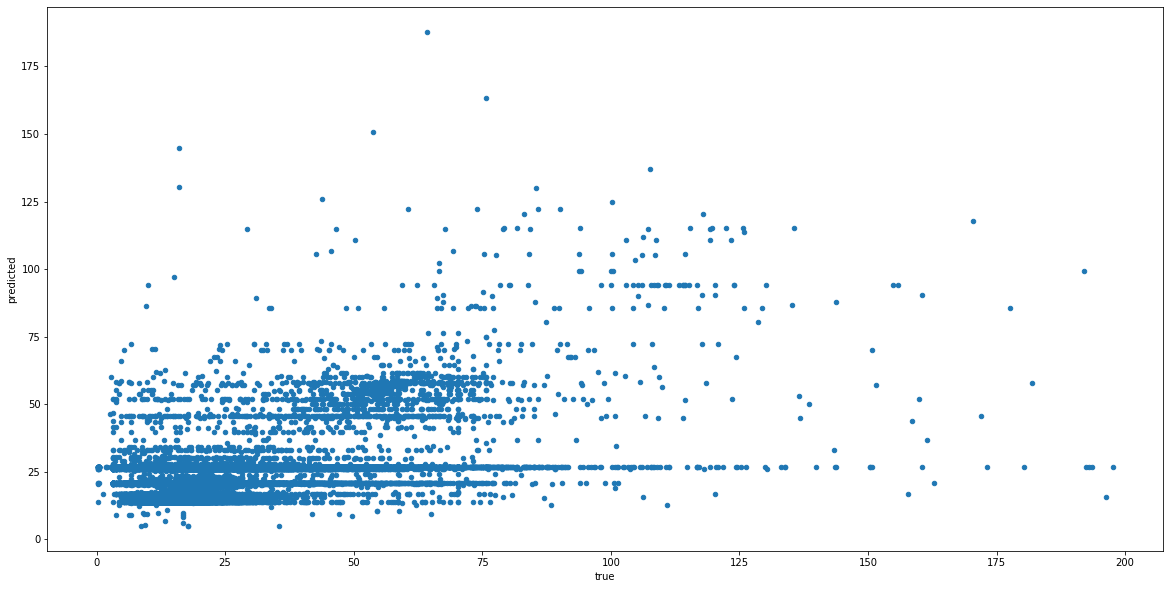

In [93]:
data = {'true': y_test, 'predicted': y_pred}

results = pd.DataFrame(data)
results.plot(figsize=(20,10), kind='scatter', x='true', y='predicted')

#### Overfit
The model fits the training data's pattern so much that it loses the ability to generalise.

In [94]:
X_train_overfit = X_train
y_train_overfit = y_train 

X_test_overfit = X_test
y_test_overfit = y_test

In [95]:
rmse_scores = {'max_depth': [], 'rmse_train': [], 'rmse_test': []}

for md in [2,5,8,9,10,11,12,15,20,30,50,70,100,150]: 
    decision_tree_overfit = DecisionTreeRegressor(max_depth=md)
    decision_tree_overfit.fit(X_train_overfit, y_train_overfit)
    
    model_at_hand_overfit = decision_tree_overfit
    
    y_pred_train = model_at_hand_overfit.predict(X_train_overfit)
    rmse_train = sqrt(mean_squared_error(y_pred_train, y_train_overfit))
    
    y_pred_test = model_at_hand_overfit.predict(X_test_overfit)
    rmse_test = sqrt(mean_squared_error(y_pred_test, y_test_overfit))
    
    rmse_scores['max_depth'].append(md)
    rmse_scores['rmse_train'].append(rmse_train)
    rmse_scores['rmse_test'].append(rmse_test)

In [96]:
pd.DataFrame(rmse_scores)

,max_depth,rmse_train,rmse_test
0,2,15.055832,14.911673
1,5,14.269573,14.147737
2,8,13.671624,13.751925
3,9,13.476012,13.693658
4,10,13.274876,13.699841
5,11,13.063929,13.770341
6,12,12.849544,13.733873
7,15,12.124662,14.034627
8,20,11.162100,14.285185
9,30,9.818285,14.745957


Text(0, 0.5, 'Root mean squared error')

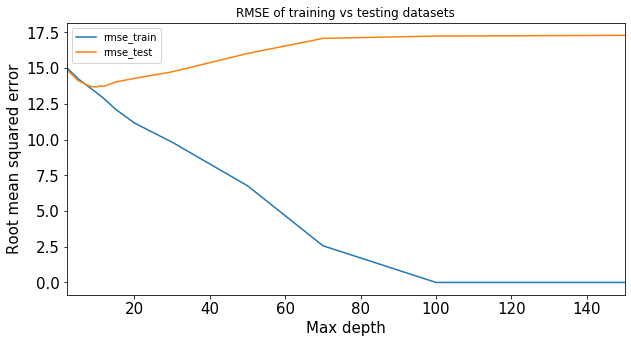

In [98]:
ax = pd.DataFrame(rmse_scores).plot(figsize=(10,5), title='RMSE of training vs testing datasets', 
                                    fontsize=15, x='max_depth')
ax.set_xlabel("Max depth", fontsize=15)
ax.set_ylabel("Root mean squared error", fontsize=15)

#### Underfit
Underfit is when the model cannot capture the data's pattern at all.

In [99]:
X_train_underfit = X_train
y_train_underfit = y_train

X_test_underfit = X_test
y_test_underfit = y_test

In [102]:
decisiontree_underfit = DecisionTreeRegressor(max_depth=1)
decisiontree_underfit.fit(X_train_underfit, y_train_underfit)

# Training performance

model_at_hand = decisiontree_underfit

y_pred_train_underfit = model_at_hand.predict(X_train_underfit)

print('mean_absolute_error', mean_absolute_error(y_train_underfit, y_pred_train_underfit))
print('mean_squared_error', mean_squared_error(y_train_underfit, y_pred_train_underfit))
print('root_mean_squared_error', sqrt(mean_squared_error(y_train_underfit, y_pred_train_underfit)))
print('r2', r2_score(y_train_underfit, y_pred_train_underfit))

mean_absolute_error 9.99962269437441
mean_squared_error 242.29725755476696
root_mean_squared_error 15.565900473623971
r2 0.12395949242460469


In [103]:
# Testing performance

y_pred_test_underfit = model_at_hand.predict(X_test_underfit)

print('mean_absolute_error', mean_absolute_error(y_test_underfit, y_pred_test_underfit))
print('mean_squared_error', mean_squared_error(y_test_underfit, y_pred_test_underfit))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test_underfit, y_pred_test_underfit)))
print('r2', r2_score(y_test_underfit, y_pred_test_underfit))

mean_absolute_error 9.988793787441008
mean_squared_error 241.37275139499613
root_mean_squared_error 15.536175571709922
r2 0.12387137471693066


### 7.2. Random forest <a id='random_forest'></a>
[Back to top](#table_of_contents)

In [110]:
from sklearn.ensemble import RandomForestRegressor

rando_model = RandomForestRegressor()
rando_model.fit(X_train, y_train)

C:\Users\huong\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [111]:
y_pred_rando = rando_model.predict(X_test)

print('mean_absolute_error', mean_absolute_error(y_test, y_pred_rando))
print('mean_squared_error', mean_squared_error(y_test, y_pred_rando)) 
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred_rando)))
print('r2', r2_score(y_test, y_pred_rando))

mean_absolute_error 7.624245549921317
mean_squared_error 180.36230458858935
root_mean_squared_error 13.429903372272987
r2 0.3453255304966336


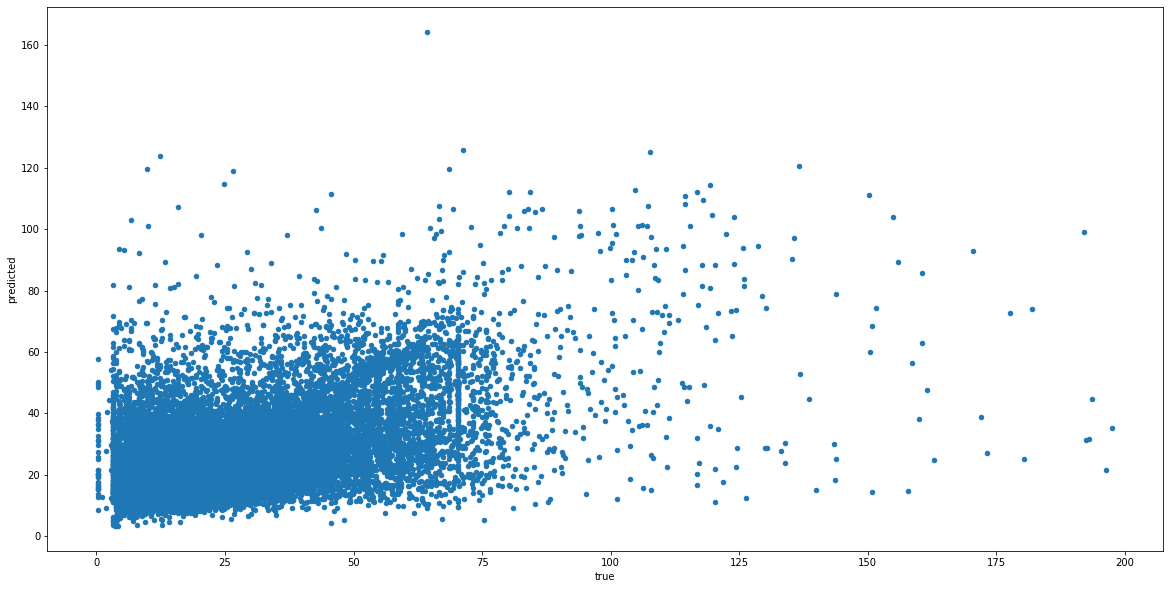

In [112]:
data = {'true': y_test, 'predicted': y_pred_rando}
results = pd.DataFrame(data)
results.plot(figsize=(20,10), kind='scatter', x='true', y='predicted')

### 7.3. Gradient Boosting <a id='gradient_boosting'></a>
[Back to top](#table_of_contents)

In [107]:
from sklearn.ensemble import GradientBoostingRegressor

gradientBooster = GradientBoostingRegressor()
gradientBooster.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [108]:
y_pred_gb = gradientBooster.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_gb))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_gb))
print('Root Mean Squared Error', sqrt(mean_squared_error(y_test, y_pred_gb)))
print('r2:', r2_score(y_test, y_pred_gb))

Mean Absolute Error: 8.313772867579956
Mean Squared Error: 172.388656208418
Root Mean Squared Error 13.129686066636095
r2: 0.3742680749778783


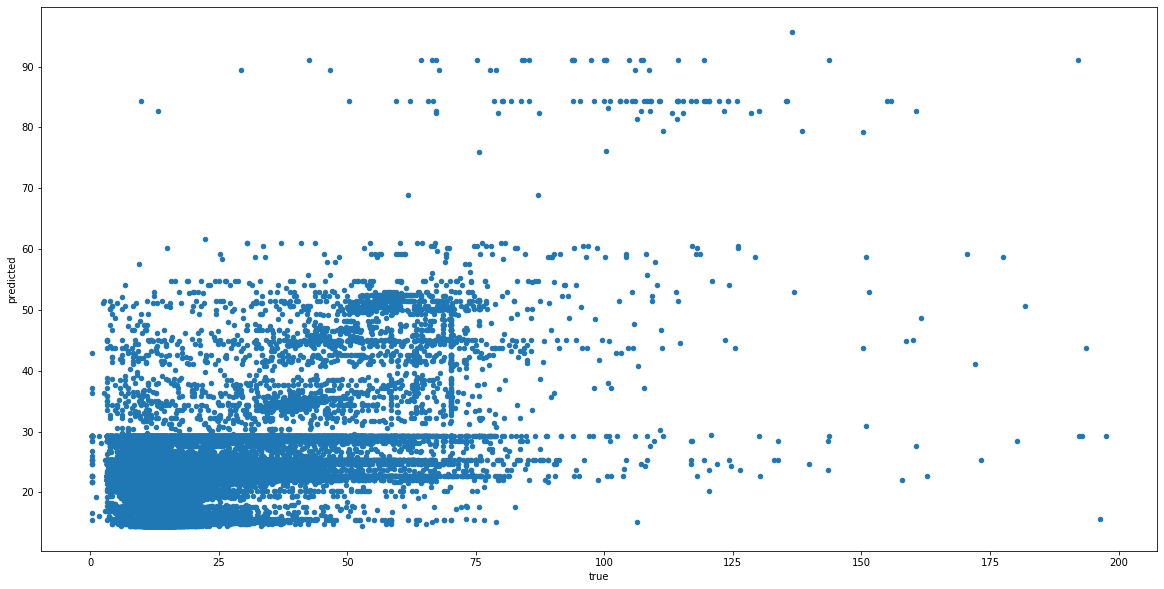

In [113]:
data = {'true': y_test, 'predicted': y_pred_gb}
results = pd.DataFrame(data)
results.plot(figsize=(20,10), kind='scatter', x='true', y='predicted')

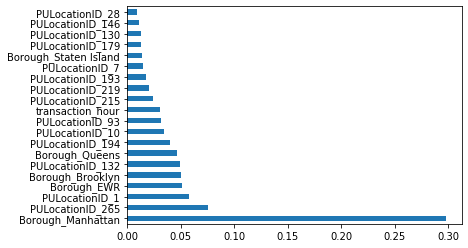

In [118]:
pd.Series(gradientBooster.feature_importances_, index=X_train.columns).nlargest(20).plot(kind='barh')

### 7.4. Comparing algorithm performances <a id='comparing_algorithm_performances'></a>
[Back to top](#table_of_contents)

| Algorithm         | MAE   | RMSE  | R2 Score |
|-------------------|-------|-------|----------|
| Benchmark Model   | 9.758 | 14.70 | 0.2158   |
| Decision Tree     | 8.451 | 13.73 | 0.3154   |
| Random Forest     | 7.624 | 13.43 | 0.3453   |
| Gradient Boosting | 8.314 | 13.13 | 0.3743   |